# Libs

In [7]:
import pandas as pd     
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
import typing
import plotly.express as px

In [10]:
np.random.seed(0)

In [8]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 25, 6

Метрики оценки качества модели

In [ ]:
THRESHOLD = 0.15
NEGATIVE_WEIGHT = 1.1

def deviation_metric_one_sample(y_true: typing.Union[float, int], y_pred: typing.Union[float, int]) -> float:
    """
    Реализация кастомной метрики для хакатона.

    :param y_true: float, реальная цена
    :param y_pred: float, предсказанная цена
    :return: float, значение метрики
    """
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    if np.abs(deviation) <= THRESHOLD:
        return 0
    elif deviation <= - 4 * THRESHOLD:
        return 9 * NEGATIVE_WEIGHT
    elif deviation < -THRESHOLD:
        return NEGATIVE_WEIGHT * ((deviation / THRESHOLD) + 1) ** 2
    elif deviation < 4 * THRESHOLD:
        return ((deviation / THRESHOLD) - 1) ** 2
    else:
        return 9


def deviation_metric(y_true: np.array, y_pred: np.array) -> float:
    return np.array([deviation_metric_one_sample(y_true[n], y_pred[n]) for n in range(len(y_true))]).mean()

def median_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.median(np.abs(y_pred-y_true)/y_true)

def metrics_stat(y_true: np.array, y_pred: np.array) -> typing.Dict[str,float]:
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mdape = median_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    raif_metric = deviation_metric(y_true, y_pred)
    return {'mape':mape, 
            'mdape':mdape, 
            'rmse': rmse, 
            'r2': r2, 
            'raif_metric':raif_metric
            }

Загрузка и обработка данных


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/raifhack/train.csv', parse_dates=['date'])
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/raifhack/test.csv', parse_dates=['date'])

In [11]:
train_df.head(5)

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,osm_catering_points_in_0.0075,osm_catering_points_in_0.01,osm_city_closest_dist,osm_city_nearest_name,osm_city_nearest_population,osm_crossing_closest_dist,osm_crossing_points_in_0.001,osm_crossing_points_in_0.005,osm_crossing_points_in_0.0075,osm_crossing_points_in_0.01,osm_culture_points_in_0.001,osm_culture_points_in_0.005,osm_culture_points_in_0.0075,osm_culture_points_in_0.01,osm_finance_points_in_0.001,osm_finance_points_in_0.005,osm_finance_points_in_0.0075,osm_finance_points_in_0.01,osm_healthcare_points_in_0.005,osm_healthcare_points_in_0.0075,osm_healthcare_points_in_0.01,osm_historic_points_in_0.005,osm_historic_points_in_0.0075,osm_historic_points_in_0.01,osm_hotels_points_in_0.005,osm_hotels_points_in_0.0075,osm_hotels_points_in_0.01,osm_leisure_points_in_0.005,osm_leisure_points_in_0.0075,osm_leisure_points_in_0.01,osm_offices_points_in_0.001,osm_offices_points_in_0.005,osm_offices_points_in_0.0075,osm_offices_points_in_0.01,osm_shops_points_in_0.001,osm_shops_points_in_0.005,osm_shops_points_in_0.0075,osm_shops_points_in_0.01,osm_subway_closest_dist,osm_train_stop_closest_dist,osm_train_stop_points_in_0.005,osm_train_stop_points_in_0.0075,osm_train_stop_points_in_0.01,osm_transport_stop_closest_dist,osm_transport_stop_points_in_0.005,osm_transport_stop_points_in_0.0075,osm_transport_stop_points_in_0.01,per_square_meter_price,reform_count_of_houses_1000,reform_count_of_houses_500,reform_house_population_1000,reform_house_population_500,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,Пермь,NaN,COL_0,57.998207,56.292797,4,19,35,52,0,0,0,0,0,2,4,6,3.293470,Пермь,1055397.0,0.027732,3,6,17,34,0,0,1,1,0,0,1,2,2,3,4,0,0,1,0,0,0,0,1,2,0,1,2,4,4,11,20,28,269.024986,3.368385,0,0,0,0.002864,4,13,21,139937.500000,136,49,2503.0,765.0,5.762963,5.530612,1964.118519,1960.959184,Пермский край,32.0,S27289,2020-01-05,10,0
1,Шатура,NaN,COL_1,55.574284,39.543835,3,24,37,59,0,0,0,1,0,2,2,6,43.950989,Орехово-Зуево,120184.0,0.089441,0,31,50,57,0,1,2,3,0,0,1,2,1,1,3,2,4,6,2,2,2,1,1,2,0,1,2,3,1,12,20,29,102.455451,1.476600,0,0,0,0.154661,4,10,11,60410.714286,146,37,1336.0,514.0,2.894366,3.527778,1952.321678,1957.222222,Московская область,280.0,S17052,2020-01-05,10,0
2,Ярославль,NaN,COL_2,57.619140,39.850525,1,30,67,128,0,0,1,1,0,3,6,11,2.676293,Ярославль,603961.0,0.200995,0,15,29,53,0,1,2,2,0,0,5,9,0,1,3,0,0,0,0,0,1,2,3,6,0,1,6,9,1,16,37,80,243.361937,1.455127,0,0,0,0.118275,9,13,21,45164.761264,105,27,1883.0,573.0,6.141414,7.222222,1968.150000,1973.370370,Ярославская область,297.4,S16913,2020-01-05,110,0
3,Новокузнецк,NaN,COL_3,53.897083,87.108604,0,0,5,21,0,0,0,1,0,0,1,4,15.618563,Новокузнецк,552105.0,0.861400,0,0,0,5,0,0,0,0,0,0,0,1,0,0,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,4,11,295.633502,9.400855,0,0,0,1.036523,0,0,3,28805.263158,75,2,1801.0,54.0,8.581081,9.000000,1992.716216,2014.000000,Кемеровская область,190.0,S10148,2020-01-05,110,0
4,Москва,NaN,COL_4,55.802590,37.487110,1,23,64,153,0,1,1,1,0,8,14,26,9.995325,Химки,232066.0,0.236744,0,14,40,78,0,0,0,0,0,0,3,9,2,7,14,0,2,2,1,1,3,3,4,9,0,8,8,12,0,8,33,89,1.110429,1.235503,0,0,0,0.235032,10,32,62,13222.591362,144,38,3090.0,619.0,7.263889,5.684211,1963.229167,1960.500000,Москва,60.2,S1338,2020-01-05,10,0


In [12]:
train_df.shape, test_df.shape

((279792, 77), (2974, 76))

In [191]:
train_df = train_df.drop(train_df[train_df['price_type'] == 0].index)
test_df = test_df.drop(test_df[test_df['price_type'] == 0].index)

In [192]:
y = train_df['per_square_meter_price']

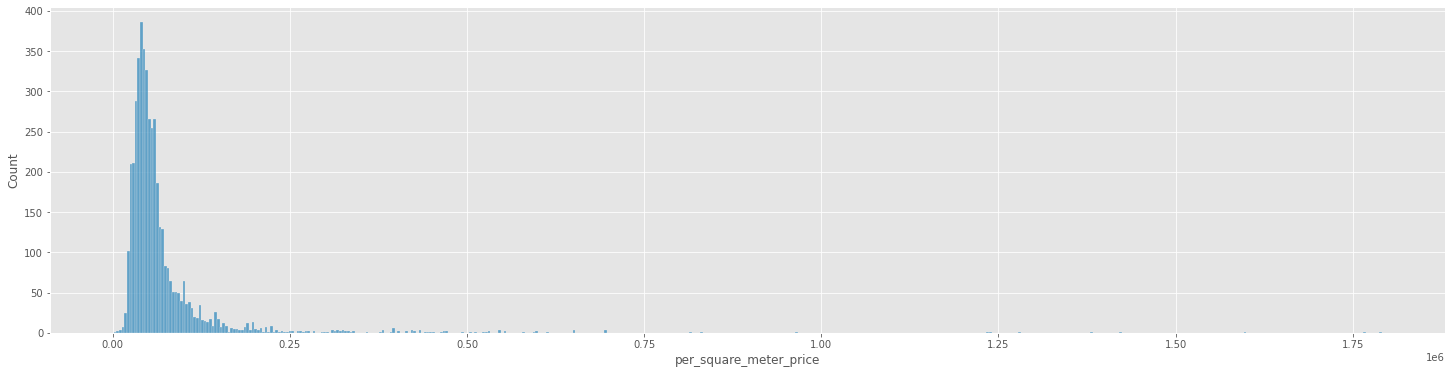

In [ ]:
sns.histplot(y);

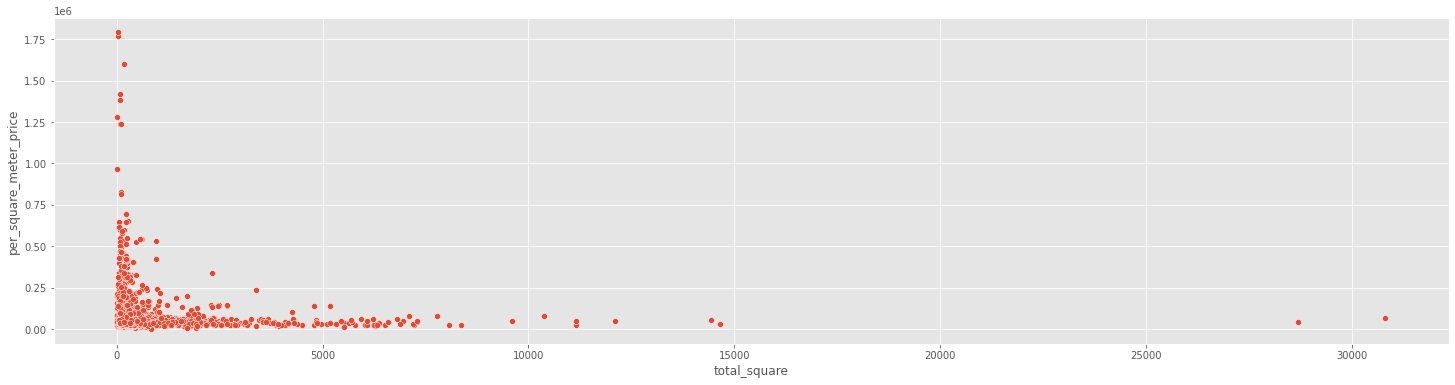

In [ ]:
sns.scatterplot(data=train_df, x='total_square', y='per_square_meter_price');

In [193]:
train_df.drop('per_square_meter_price', axis=1, inplace=True)

In [194]:
# For submission csv 
idx = test_df['id']
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

Графики

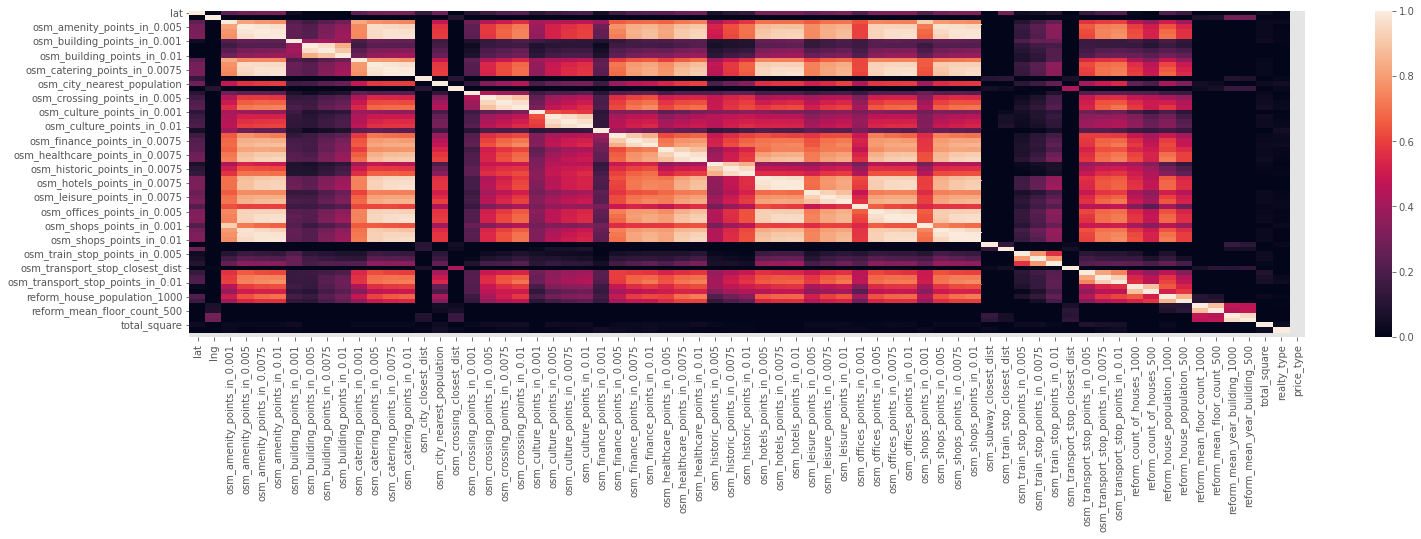

In [ ]:
sns.heatmap(train_df.corr(), vmin=0, vmax=1);

In [26]:
train_df.describe()

,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,osm_catering_points_in_0.0075,osm_catering_points_in_0.01,osm_city_closest_dist,osm_city_nearest_population,osm_crossing_closest_dist,osm_crossing_points_in_0.001,osm_crossing_points_in_0.005,osm_crossing_points_in_0.0075,osm_crossing_points_in_0.01,osm_culture_points_in_0.001,osm_culture_points_in_0.005,osm_culture_points_in_0.0075,osm_culture_points_in_0.01,osm_finance_points_in_0.001,osm_finance_points_in_0.005,osm_finance_points_in_0.0075,osm_finance_points_in_0.01,osm_healthcare_points_in_0.005,osm_healthcare_points_in_0.0075,osm_healthcare_points_in_0.01,osm_historic_points_in_0.005,osm_historic_points_in_0.0075,osm_historic_points_in_0.01,osm_hotels_points_in_0.005,osm_hotels_points_in_0.0075,osm_hotels_points_in_0.01,osm_leisure_points_in_0.005,osm_leisure_points_in_0.0075,osm_leisure_points_in_0.01,osm_offices_points_in_0.001,osm_offices_points_in_0.005,osm_offices_points_in_0.0075,osm_offices_points_in_0.01,osm_shops_points_in_0.001,osm_shops_points_in_0.005,osm_shops_points_in_0.0075,osm_shops_points_in_0.01,osm_subway_closest_dist,osm_train_stop_closest_dist,osm_train_stop_points_in_0.005,osm_train_stop_points_in_0.0075,osm_train_stop_points_in_0.01,osm_transport_stop_closest_dist,osm_transport_stop_points_in_0.005,osm_transport_stop_points_in_0.0075,osm_transport_stop_points_in_0.01,reform_count_of_houses_1000,reform_count_of_houses_500,reform_house_population_1000,reform_house_population_500,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,total_square,realty_type,price_type
count,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4.492000e+03,4493.000000,4493.000000,4493.000000,4493.000000,4493.00000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.00000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.00000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4438.000000,4425.000000,4430.000000,4415.000000,4432.000000,4417.000000,4493.000000,4493.000000,4493.0
mean,55.493987,62.994769,3.660806,60.134654,123.217672,200.029379,0.017805,0.457823,0.948587,1.611618,0.951258,15.668596,32.073002,51.310260,8.609045,1.283869e+06,0.165989,1.006232,17.850879,36.876252,60.84398,0.121968,2.617627,5.660583,9.549967,0.231249,3.043401,5.945248,9.45582,2.521700,5.340975,8.834187,2.394391,5.274427,8.900512,3.189406,6.549521,10.431115,2.324060,4.796350,7.987314,0.385266,5.366125,11.074338,18.072780,2.12219,33.458491,67.715558,109.098820,206.558171,10.764812,0.057200,0.136434,0.255509,0.158180,7.575562,15.345426,24.939684,155.816381,46.413755,2681.790221,798.831638,6.170040,6.319169,1962.463689,1962.856188,415.088403,57.852215,1.0
std,3.472989,27.541145,5.178236,82.203418,171.623007,282.781454,0.143558,2.572513,4.212338,6.279752,2.208234,31.067737,64.582611,104.331943,32.304411,1.871338e+06,0.311540,1.600160,14.726401,29.100791,47.52683,0.467835,6.861158,13.366131,20.843884,0.568687,3.888945,7.079980,10.86174,3.858158,7.720110,12.836854,4.122272,8.213137,13.018674,9.606225,19.304562,30.365941,3.619237,6.787361,10.905694,0.963966,10.540647,21.871148,36.076361,3.44302,48.174335,97.534087,158.813589,312.429857,25.757514,0.491762,0.823379,1.136565,0.240010,5.435561,9.614403,14.906585,94.310158,29.615155,1465.854860,449.691311,2.604755,3.022392,33.448532,

In [ ]:
fig = px.histogram(train_df, x="total_square")
fig.show()

Логарифируем для сокращения ассиметрии.

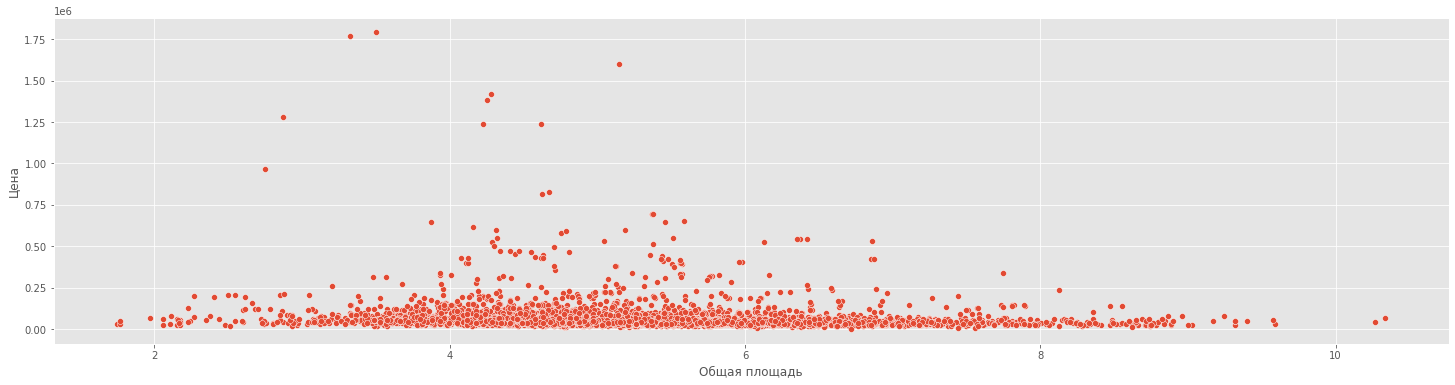

In [ ]:
sns.scatterplot(x=np.log(train_df['total_square']), y = y);
plt.xlabel('Общая площадь');
plt.ylabel('Цена');

# Обработка данных

In [195]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
floor,2464,0.548409
reform_mean_floor_count_500,78,0.017360
reform_mean_year_building_500,76,0.016915
reform_house_population_500,68,0.015135
reform_mean_floor_count_1000,63,0.014022
reform_mean_year_building_1000,61,0.013577
reform_house_population_1000,55,0.012241
street,17,0.003784
osm_city_nearest_population,1,0.000223
osm_culture_points_in_0.005,0,0.000000


In [196]:
UNKNOWN_VALUE = 'missing'
fillna_cols = ['region','city','street','realty_type']
train_df[fillna_cols] = train_df[fillna_cols].fillna(UNKNOWN_VALUE)
test_df[fillna_cols] = test_df[fillna_cols].fillna(UNKNOWN_VALUE)

In [197]:
train_df = train_df.drop((missing_data[missing_data['Total'] > 15]).index,1)
train_df = train_df.apply(lambda x:x.fillna(x.value_counts().index[0]))
train_df.isnull().sum().max()

0

In [198]:
test_df = test_df.drop((missing_data[missing_data['Total'] > 15]).index,1)
test_df = test_df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [199]:
train_df.isna().sum().max()

0

In [200]:
train_df.drop(['lat', 'lng'], axis=1, inplace=True)

Применяем логарифмирование для обучающей и тестовой выборки.

In [201]:
train_df['total_square_log'] = np.log(train_df['total_square'])
test_df['total_square_log'] = np.log(test_df['total_square'])

In [202]:
train_df.drop(['total_square'], axis=1, inplace=True)
test_df.drop(['total_square'], axis=1, inplace=True)

In [203]:
train_df['month'] = pd.DatetimeIndex(train_df['date']).month
test_df['month'] = pd.DatetimeIndex(test_df['date']).month

In [204]:
one_hot_train_df = pd.get_dummies(train_df, columns = list(train_df.select_dtypes(include='object').columns))

In [205]:
one_hot_test_df = pd.get_dummies(test_df, columns = list(test_df.select_dtypes(include='object').columns))

In [206]:
x_train, x_test, y_train, y_test = train_test_split(one_hot_train_df.drop('date', axis=1), y, test_size=.2, random_state=242625)

In [207]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest

In [208]:
model = mutual_info_regression(x_train, y_train)

In [209]:
#Select top 10 features based on mutual info regression
selector = SelectKBest(mutual_info_regression, k =10)
selector.fit(x_train, y_train)
features = x_train.columns[selector.get_support()]

In [210]:
features

Index(['osm_amenity_points_in_0.005', 'osm_amenity_points_in_0.0075',
       'osm_amenity_points_in_0.01', 'osm_catering_points_in_0.0075',
       'osm_catering_points_in_0.01', 'osm_city_nearest_population',
       'osm_crossing_points_in_0.01', 'osm_offices_points_in_0.01',
       'osm_shops_points_in_0.01', 'osm_subway_closest_dist'],
      dtype='object')

In [98]:
cat_feature = np.where(train_df.dtypes == 'object')[0].tolist()

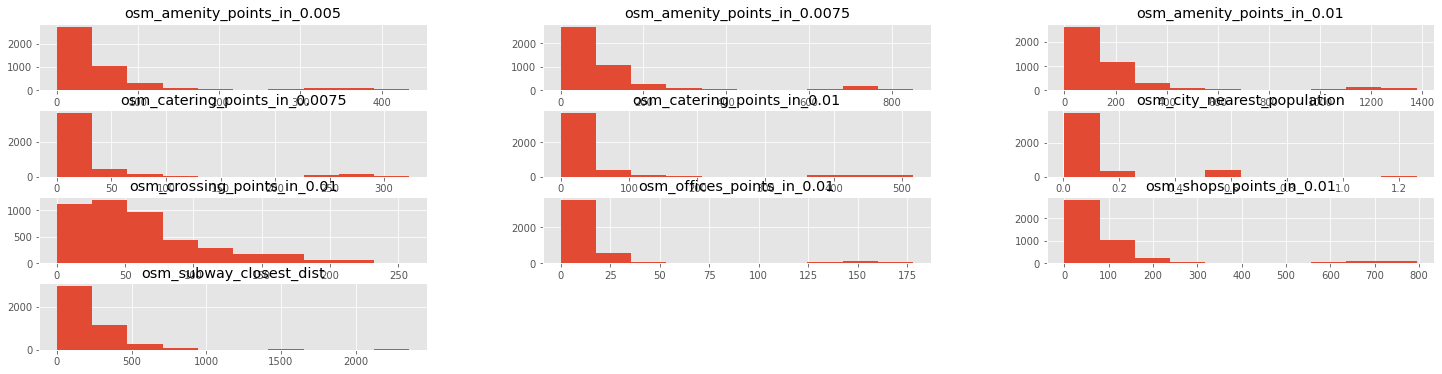

In [213]:
train_df[features].hist();

In [ ]:
train_df[features[0]] = np.log(train_df[features[0]])
test_df[features[0]] = np.log(test_df[features[0]])

train_df[features[1]] = np.log(train_df[features[1]])
test_df[features[1]] = np.log(test_df[features[1]])

train_df[features[3]] = np.log(train_df[features[3]])
test_df[features[3]] = np.log(test_df[features[3]])

train_df[features[4]] = np.log(train_df[features[4]])
test_df[features[4]] = np.log(test_df[features[4]])

train_df[features[5]] = np.log(train_df[features[5]])
test_df[features[5]] = np.log(test_df[features[5]])

train_df[features[6]] = np.log(train_df[features[6]])
test_df[features[6]] = np.log(test_df[features[6]])

In [193]:
train_df.head(5)

,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,osm_catering_points_in_0.0075,osm_catering_points_in_0.01,osm_city_closest_dist,osm_city_nearest_population,osm_crossing_closest_dist,osm_crossing_points_in_0.001,osm_crossing_points_in_0.005,osm_crossing_points_in_0.0075,osm_crossing_points_in_0.01,osm_culture_points_in_0.001,osm_culture_points_in_0.005,osm_culture_points_in_0.0075,osm_culture_points_in_0.01,osm_finance_points_in_0.001,osm_finance_points_in_0.005,osm_finance_points_in_0.0075,osm_finance_points_in_0.01,osm_healthcare_points_in_0.005,osm_healthcare_points_in_0.0075,osm_healthcare_points_in_0.01,osm_historic_points_in_0.005,osm_historic_points_in_0.0075,osm_historic_points_in_0.01,osm_hotels_points_in_0.005,osm_hotels_points_in_0.0075,osm_hotels_points_in_0.01,osm_leisure_points_in_0.005,osm_leisure_points_in_0.0075,osm_leisure_points_in_0.01,osm_offices_points_in_0.001,osm_offices_points_in_0.005,osm_offices_points_in_0.0075,osm_offices_points_in_0.01,osm_shops_points_in_0.001,osm_shops_points_in_0.005,osm_shops_points_in_0.0075,osm_shops_points_in_0.01,osm_subway_closest_dist,osm_train_stop_closest_dist,osm_train_stop_points_in_0.005,osm_train_stop_points_in_0.0075,osm_train_stop_points_in_0.01,osm_transport_stop_closest_dist,osm_transport_stop_points_in_0.005,osm_transport_stop_points_in_0.0075,osm_transport_stop_points_in_0.01,reform_count_of_houses_1000,reform_count_of_houses_500,realty_type,price_type,total_square_log
275299,0,1.945910,2.639057,26,0,0,0,0,0,0,-inf,0.693147,7.795659,13.906526,0.041323,2,6,25,3.555348,0,0,0,2,0,1,2,3,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,5,10,15,1.087101,2.281425,0,0,0,0.052809,7,15,21,95,31,110,1,4.666746
275300,13,5.288267,5.843544,462,0,0,0,0,4,44,4.189655,4.488636,0.987160,13.643650,0.144936,0,4,34,4.077537,0,1,6,9,0,13,22,27,7,17,27,4,7,9,2,5,7,11,16,20,1,11,21,28,8,125,218,286,357.425239,1.924421,0,0,0,0.045451,22,34,45,502,104,10,1,5.165012
275301,3,2.708050,3.135494,33,0,0,0,0,0,1,1.098612,1.386294,3.730568,13.906526,0.141526,0,16,35,4.025352,0,0,0,0,2,3,3,3,0,1,1,3,3,3,0,0,1,2,2,2,0,2,2,3,1,5,10,18,1.621353,0.579096,0,0,2,0.223787,6,11,18,175,66,10,1,4.494629
275302,0,2.302585,3.258097,40,0,1,1,1,0,2,1.791759,2.079442,2.344310,13.343203,0.281491,0,6,6,1.791759,0,0,0,0,0,0,0,1,0,4,4,0,0,0,0,1,2,1,2,2,0,1,1,1,0,5,11,21,61.562546,0.813594,0,0,2,0.266067,8,11,19,230,56,10,1,6.039201
275303,4,3.871201,4.290459,92,0,0,6,6,1,7,2.397895,2.708050,2.170184,12.859504,0.065996,1,19,28,3.828641,1,5,10,11,0,2,2,4,3,3,4,2,2,2,0,2,2,10,11,15,0,0,0,0,1,19,29,36,555.411948,2.505330,0,0,0,0.092583,7,17,22,131,35,10,1,7.001886


In [194]:
train_df.shape, y.shape

((4493, 61), (4493,))

In [100]:
x_train, x_test, y_train, y_test = train_test_split(train_df, np.log(y), test_size=.2, shuffle=True, random_state=242625)

In [107]:
model_cb = CatBoostRegressor(iterations=5000, learning_rate=0.02,
                        cat_features=cat_feature, random_state=13, verbose=5000)
model_cb.fit(x_train, y_train)

0:	learn: 0.5906444	total: 32.6ms	remaining: 2m 42s
4999:	learn: 0.1241958	total: 57.5s	remaining: 0us


In [108]:
EPS = 1e-8
deviation_metric(np.array(y_test), np.array(model_cb.predict(x_test)))

0.00022236789781951901

In [125]:
importances = model_cb.feature_importances_

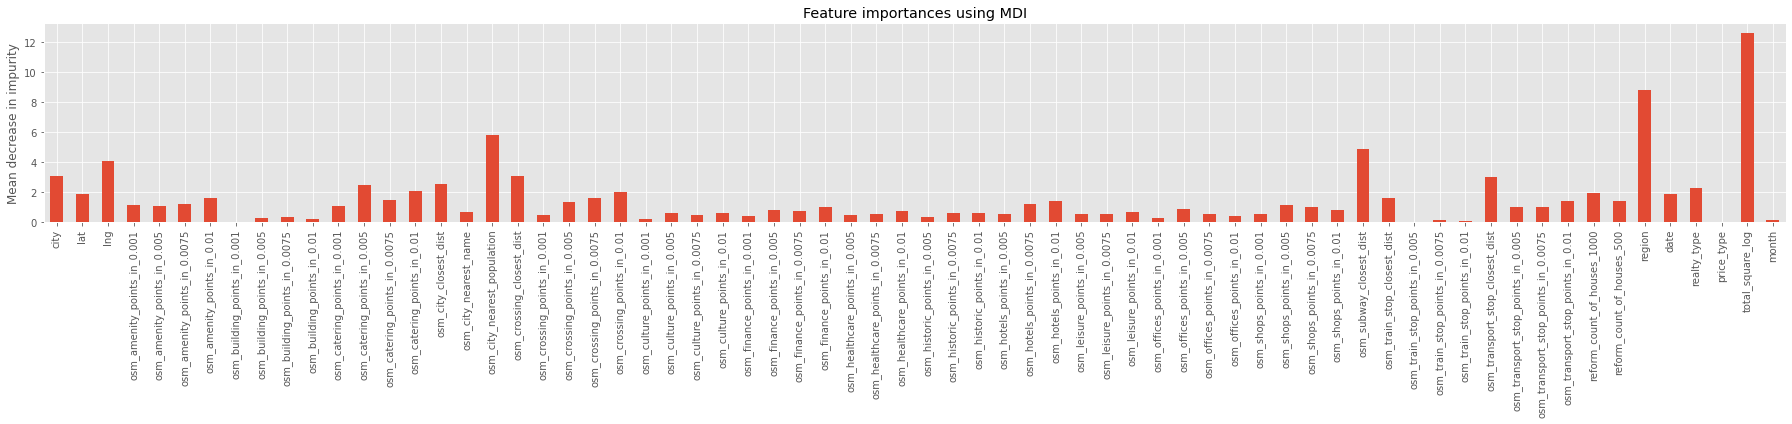

In [126]:
feature_names = x_train.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
pd.DataFrame(forest_importances).sort_values(by=0).tail(20)

In [ ]:
my_submission = pd.DataFrame({'id': idx, 'per_square_meter_price': np.exp(model_cb.predict(test_df))})
my_submission.to_csv('sub_catboost.csv', index=False)